In [45]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

def graficar(name):
    import numpy as np
    import statsmodels.api as sm
    import matplotlib.patches as mpatches

    df = desfunador(name)

    df.index = pd.to_datetime(df['Date'])
    df.drop(columns='Date', inplace=True)

    nulos = df['Close'].isnull().sum()

    if nulos > 0:
        df = df.interpolate()

    # NOMBRE DE LA GRÁFICA
    name = name.split('.')[0]

    # --------------------------------------

    # GRÁFICA ORIGINAL
    ofig, oaxs = plt.subplots(1, figsize=(20, 7))
    ofig.suptitle('Original {}.MX Graph'.format(name), fontsize=30)
    oaxs.plot(df, c='black')
    oaxs.set_xlabel('Year')
    oaxs.set_ylabel('Close price')

    # ---------------------------------------------
    #MONTH PLOT
    mfig, maxs = plt.subplots(1, figsize=(20, 7))
    month_plot_oswo(df, ylabel='close price', ax=maxs)
    mfig.suptitle('{}.MX Seasonal Subseries Plot'.format(name), fontsize=30)
    red_patch = mpatches.Patch(color='red', label='Monthly average')
    mfig.legend(handles=[red_patch])

    # -----------------------------------------------------
    # DESCOMPOSICION
    fig, axs = plt.subplots(3, 2, sharex='col', figsize=(20,7), gridspec_kw={'hspace': 0.05, 'wspace': 0.01})
    fig.suptitle('{}.MX Decomposition Graph'.format(name), fontsize=30, y=1.02);

    (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs


    # apple
    df_log = df.apply(np.log)

    decomposition = sm.tsa.seasonal_decompose(df, model='multiplicative')
    decomposition_log = sm.tsa.seasonal_decompose(df_log, model='multiplicative')

    ax1.plot(decomposition.trend, c='green')
    ax1.set(ylabel='Trend')
    ax1.set_title('ORIGINAL', pad=15, fontsize=15)
    ax2.plot(decomposition_log.trend, color='green')
    ax2.set_title('LOGARITHMIC', pad=15, fontsize=15)

    ax3.plot(decomposition.seasonal, color='darkblue')
    ax3.set(ylabel='Season')
    ax4.plot(decomposition.seasonal, color='darkblue')

    ax5.plot(decomposition.resid, color='darkred')
    ax5.set(ylabel='Irregularity', xlabel='Year')
    ax6.plot(decomposition.resid, color='darkred')
    ax6.set(xlabel='Year')

    plt.show()

# modificación para que los meses se vean más bonitos
def month_plot_oswo(x, dates=None, ylabel=None, ax=None):
    """
    Seasonal plot of monthly data.

    Parameters
    ----------
    x : array_like
        Seasonal data to plot. If dates is None, x must be a pandas object
        with a PeriodIndex or DatetimeIndex with a monthly frequency.
    dates : array_like, optional
        If `x` is not a pandas object, then dates must be supplied.
    ylabel : str, optional
        The label for the y-axis. Will attempt to use the `name` attribute
        of the Series.
    ax : Axes, optional
        Existing axes instance.

    Returns
    -------
    Figure
       If `ax` is provided, the Figure instance attached to `ax`. Otherwise
       a new Figure instance.

    Examples
    --------
    >>> import statsmodels.api as sm
    >>> import pandas as pd

    >>> dta = sm.datasets.elnino.load_pandas().data
    >>> dta['YEAR'] = dta.YEAR.astype(int).astype(str)
    >>> dta = dta.set_index('YEAR').T.unstack()
    >>> dates = pd.to_datetime(list(map(lambda x: '-'.join(x) + '-1',
    ...                                 dta.index.values)))
    >>> dta.index = pd.DatetimeIndex(dates, freq='MS')
    >>> fig = sm.graphics.tsa.month_plot(dta)

    .. plot:: plots/graphics_tsa_month_plot.py
    """

    if dates is None:
        from statsmodels.tools.data import _check_period_index

        _check_period_index(x, freq="M")
    else:
        x = pd.Series(x, index=pd.PeriodIndex(dates, freq="M"))

    xticklabels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Ago", "Sept", "Oct", "Nov", "Dec"]

    from statsmodels.graphics.tsaplots import seasonal_plot as seasonal_plot

    return seasonal_plot(
        x.groupby(lambda y: y.month), xticklabels, ylabel=ylabel, ax=ax
    )


def desfunador(name, guardar=False):
    # nos quedamos las columnas útiles
    original = pd.read_csv(name)[['Date', 'Close']]

    df = original.copy()
    # extraemos año y mes
    df['year'] = pd.to_datetime(df['Date']).dt.year
    df['month'] = pd.to_datetime(df['Date']).dt.month

    # agrupamos 
    df2 = df.groupby(['month', 'year']).mean().unstack()


    # sum and avg
    dff = df2.append([df2.sum(axis=0), df2.mean(axis=0)], ignore_index=True)

#     df2['Close'].drop(columns=2020).plot(title=archivo, cmap='cool', legend=False)

    if guardar:
        # imprudencia
        df = pd.read_csv(name)[['Date', 'Close']]

        df3 = pd.DataFrame()

        for i in range(2012,2021):
            df3[i] = (df2['Close'][i] / df2.mean(axis=0)['Close'][i] ) * 100

        df3['promedio por mes'] = df3.mean(axis=1)

        df4 = df.copy()

        tend = df.copy()

        tend['X'] = list(range(1, len(tend) + 1))

        df4['Estacionalidad'] = df3.melt()['value']

        df4['Desestacionalizado'] = (df4['Close'] / df4['Estacionalidad']) * 100

        archivo = name.split('.')[0]

        with pd.ExcelWriter('{}-PR.xlsx'.format(archivo)) as writer:
            df.to_excel(writer, sheet_name='ORIGINAL')
            dff.to_excel(writer, sheet_name='TABLA')
            df3.to_excel(writer, sheet_name='ESTACIONALIDAD')
            tend.to_excel(writer, sheet_name='TENDENCIA')
            df4.to_excel(writer, sheet_name='RESULTADOS')

    return original

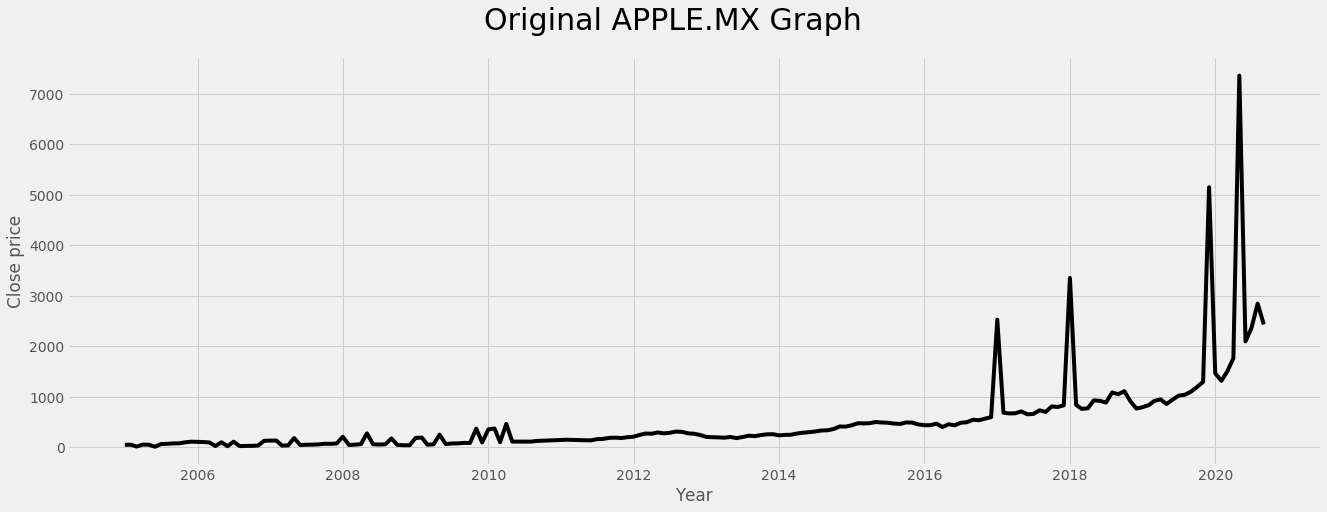

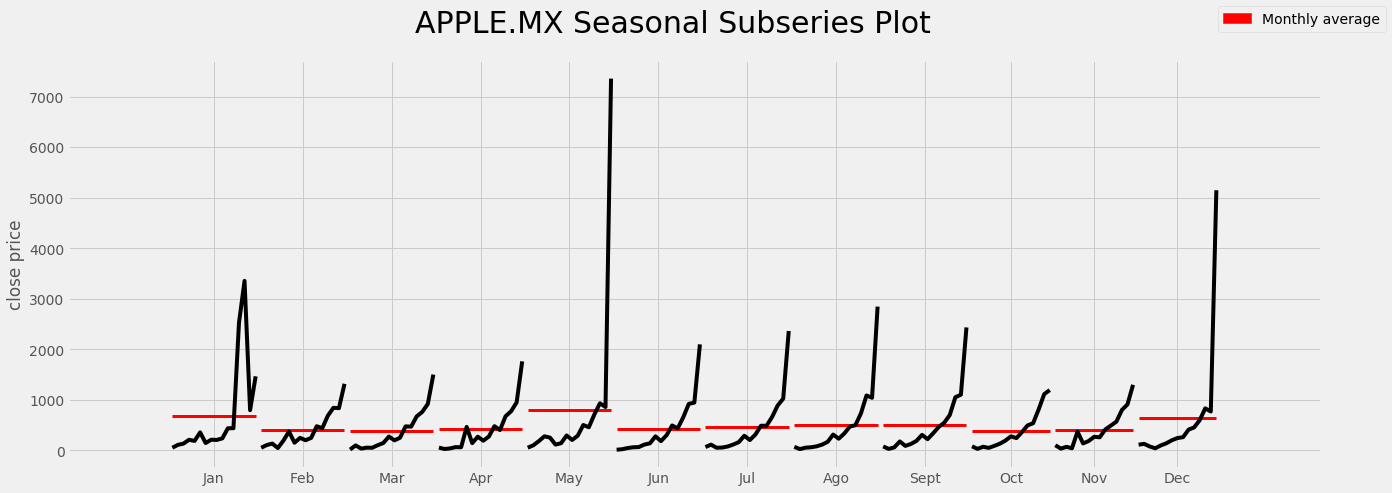

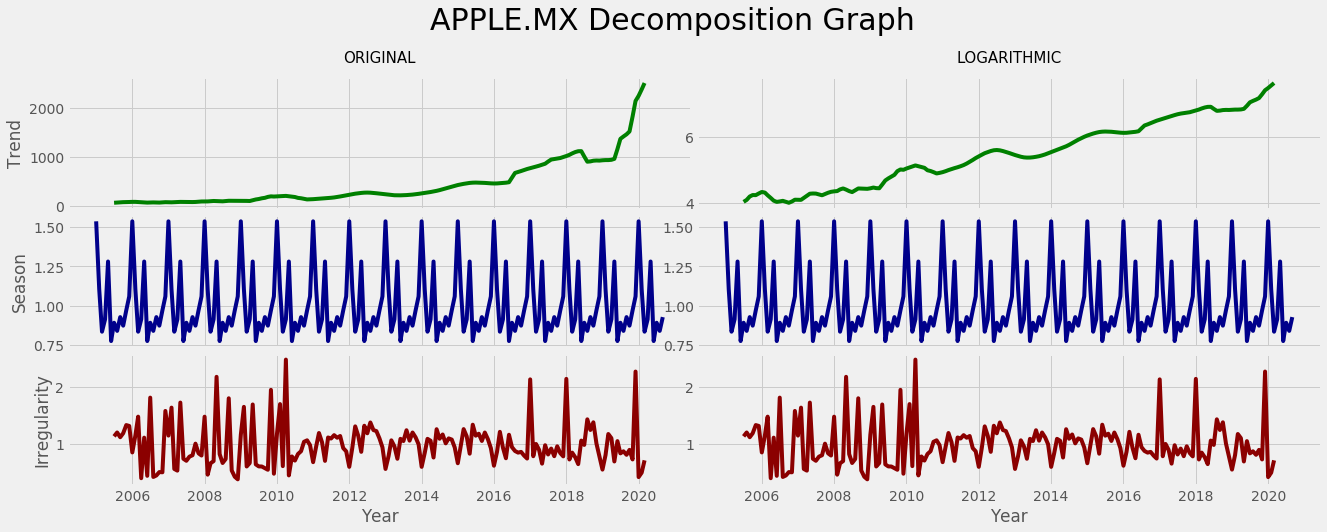

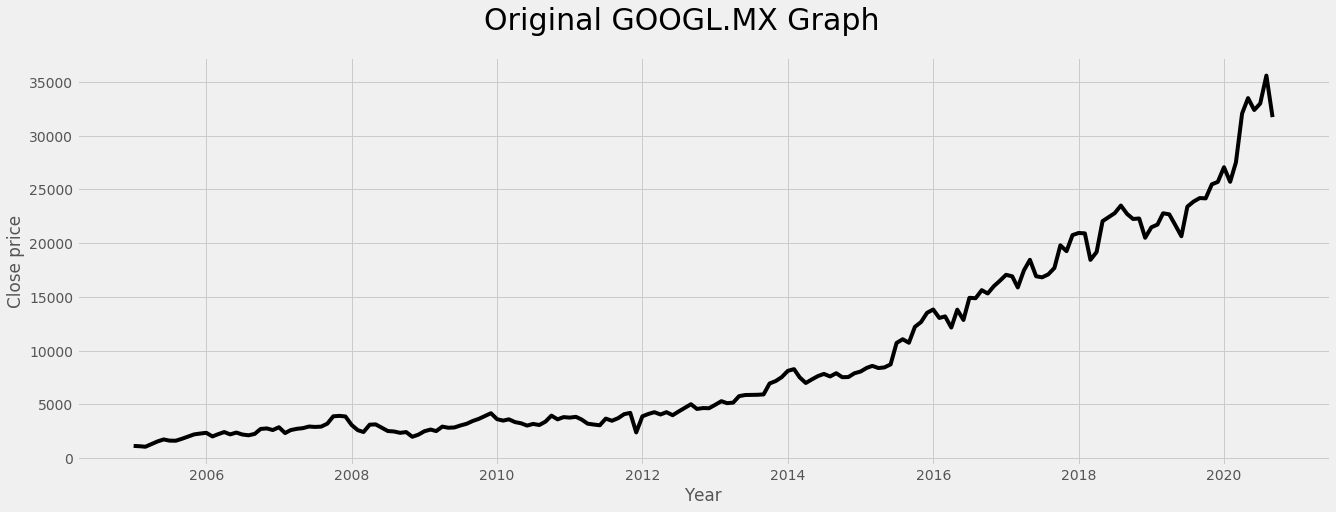

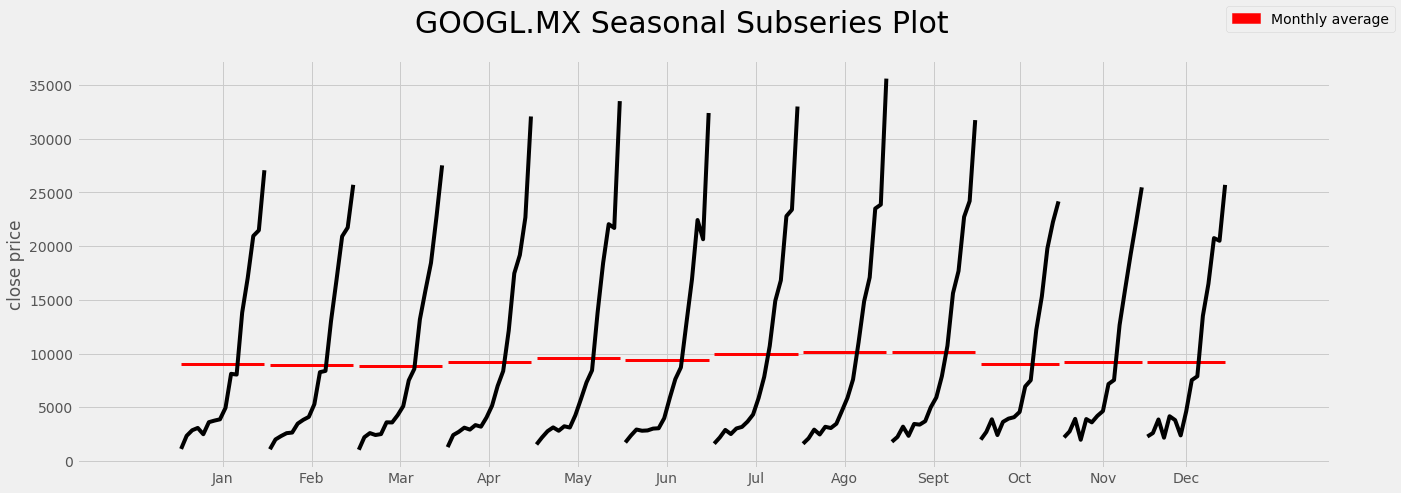

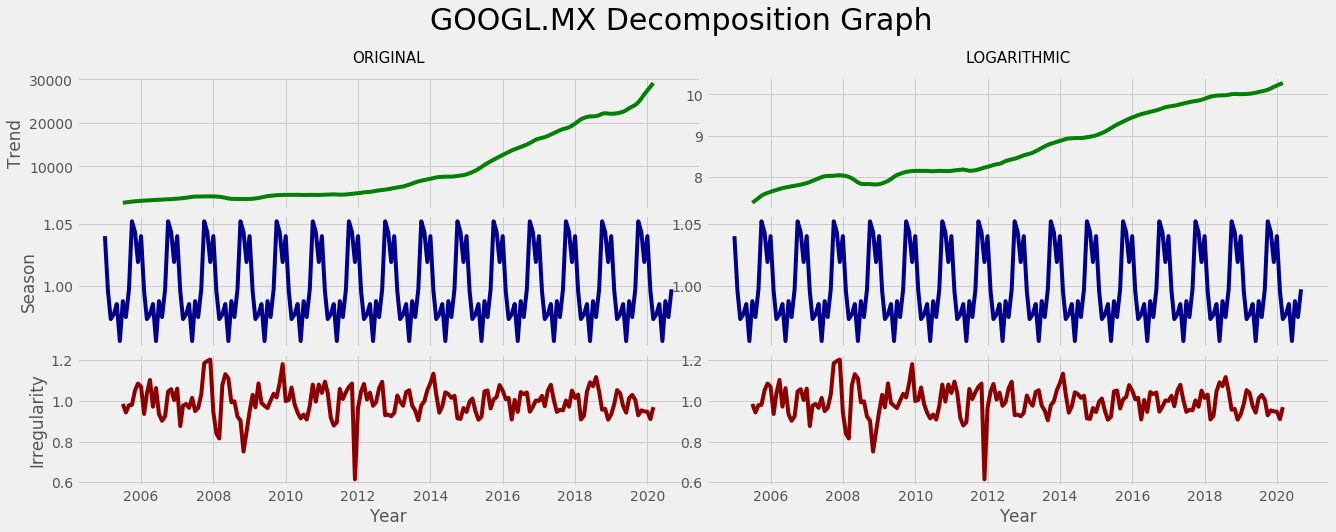

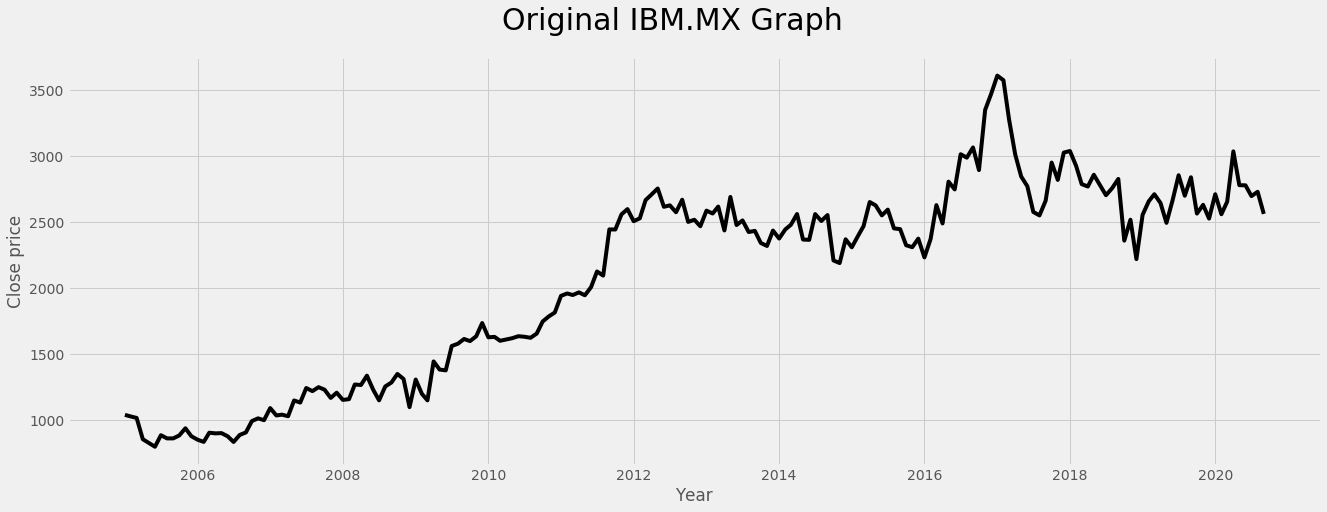

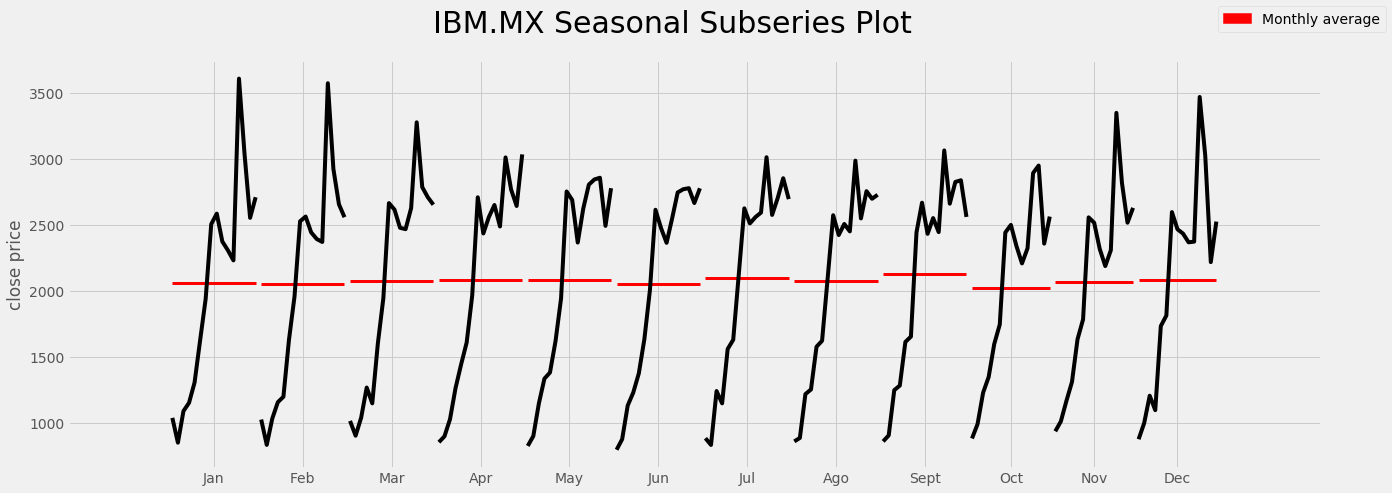

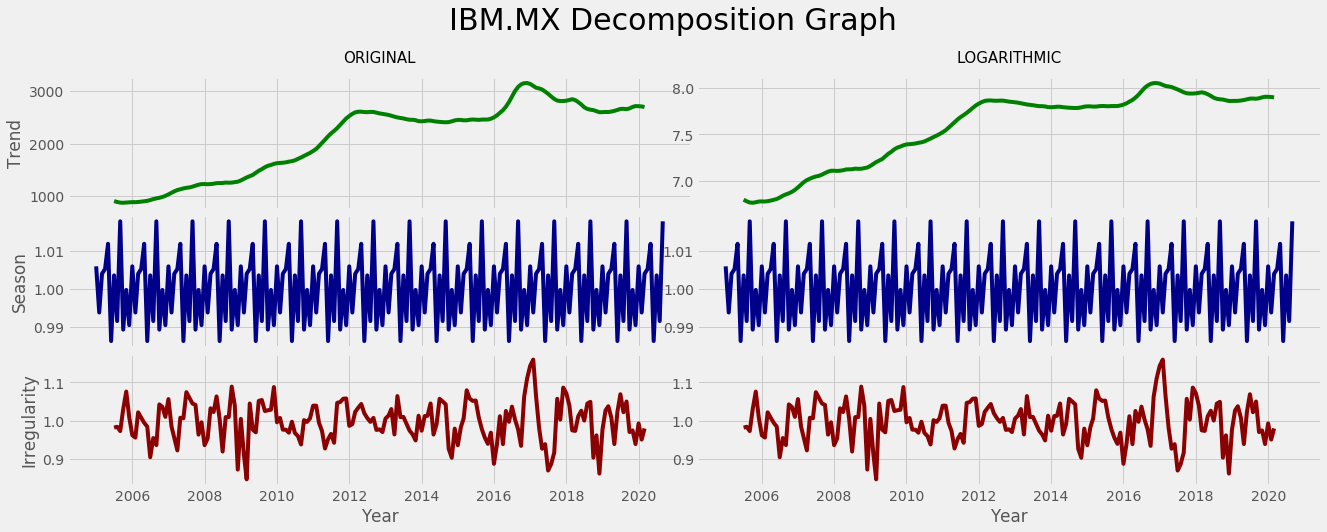

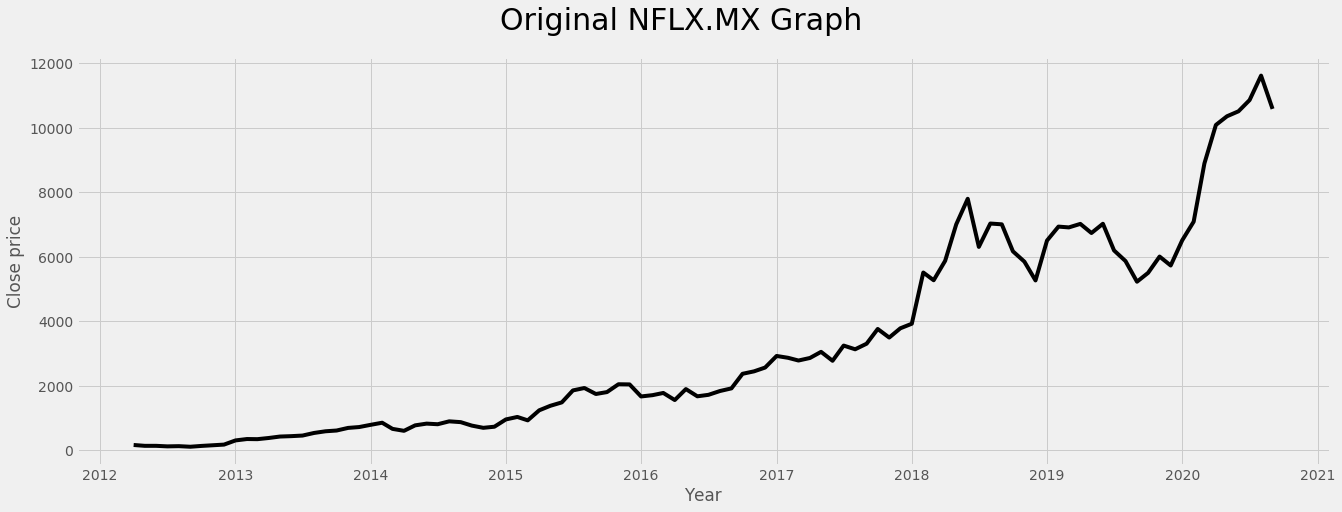

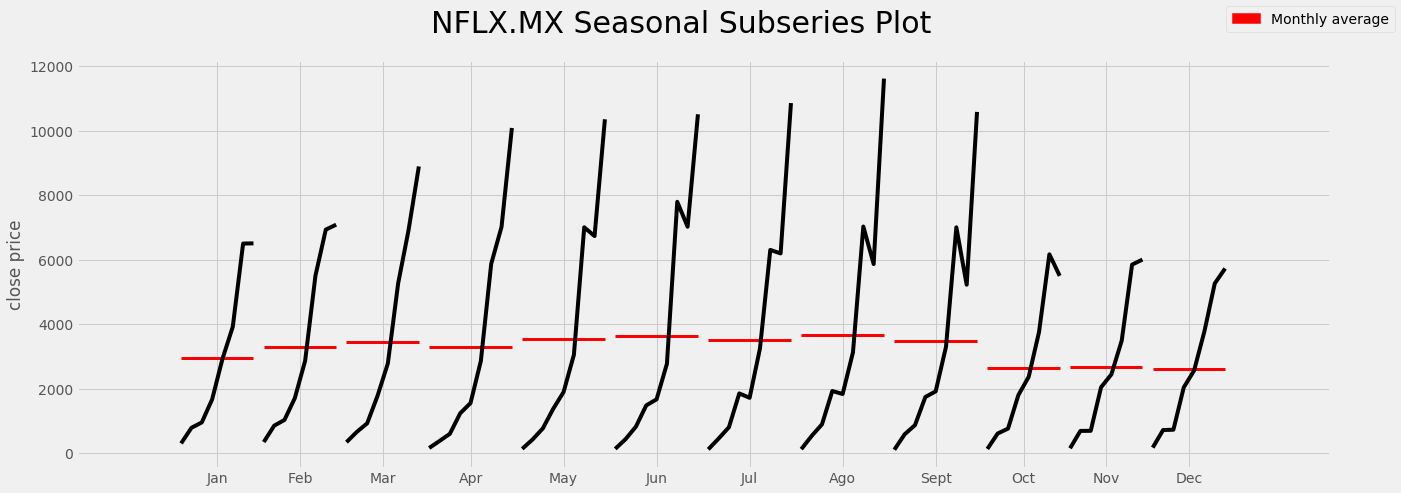

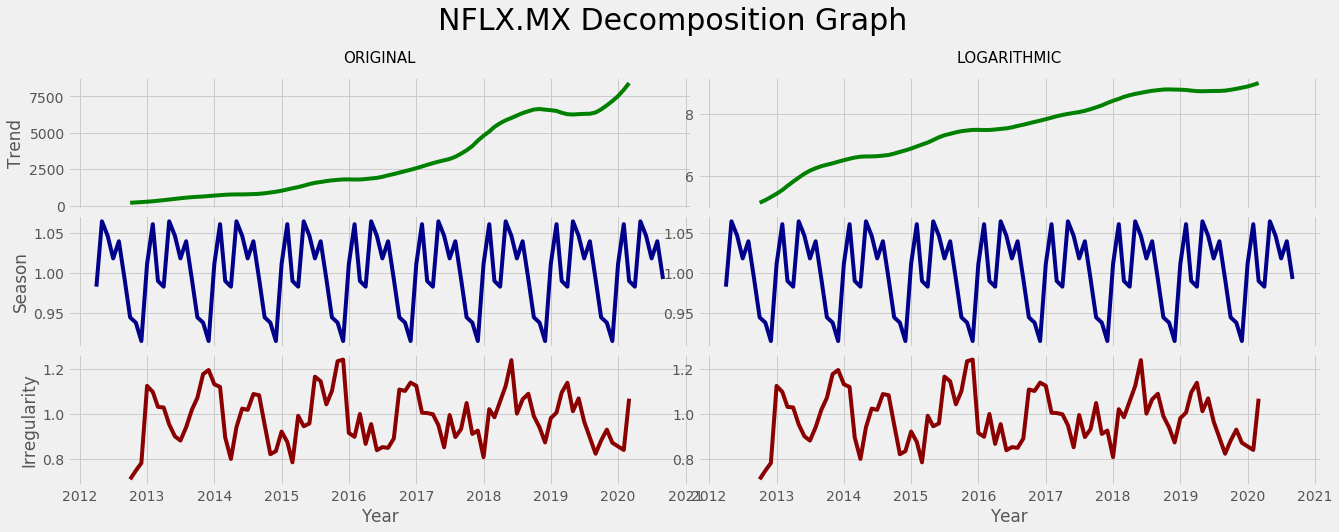

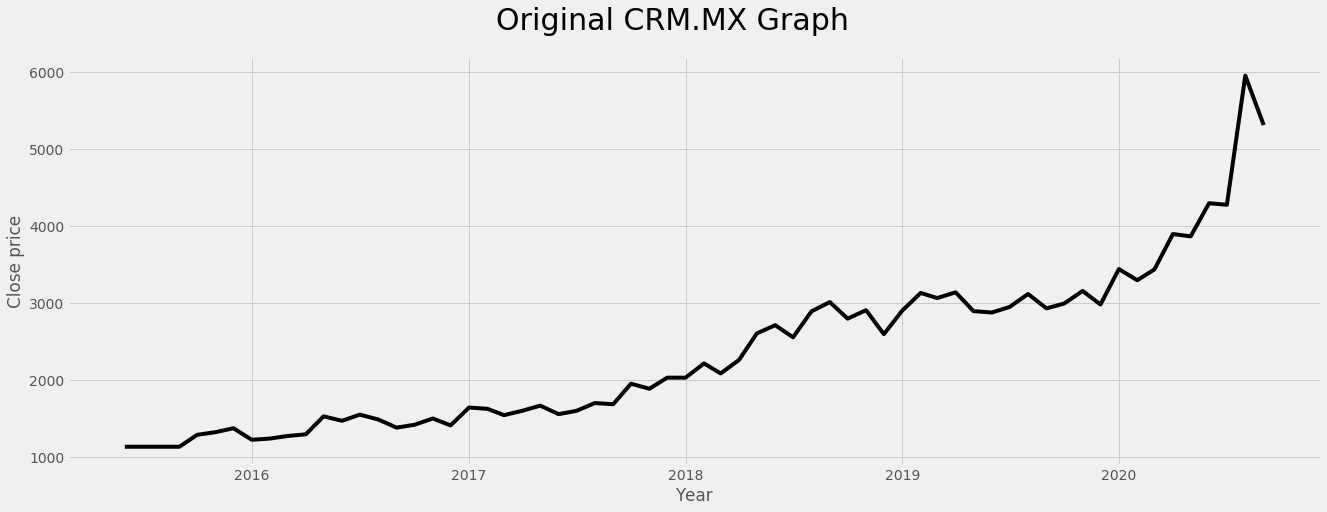

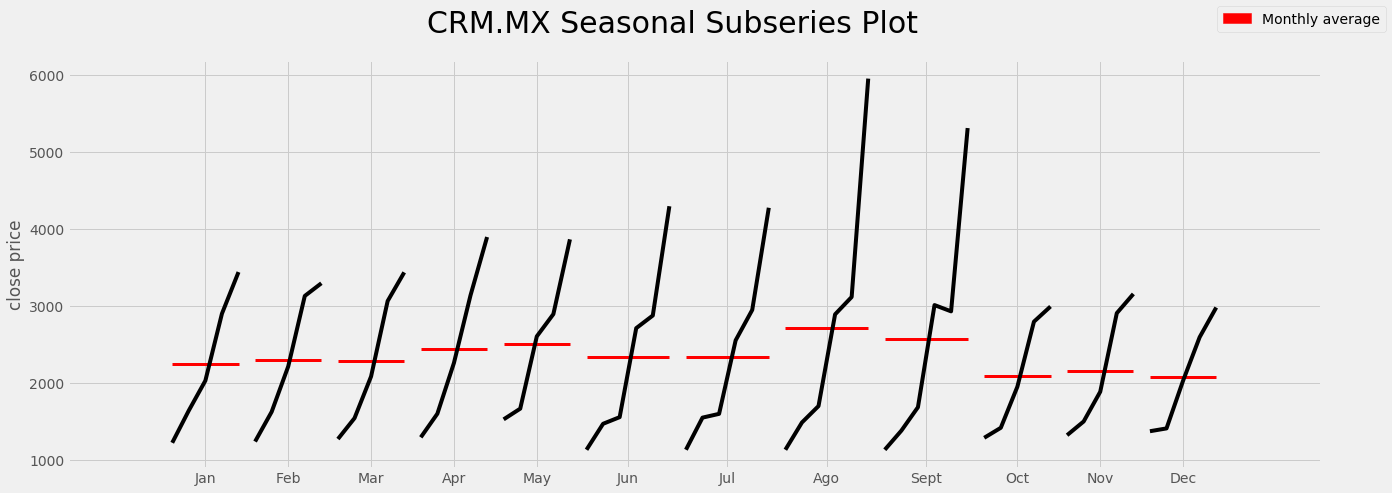

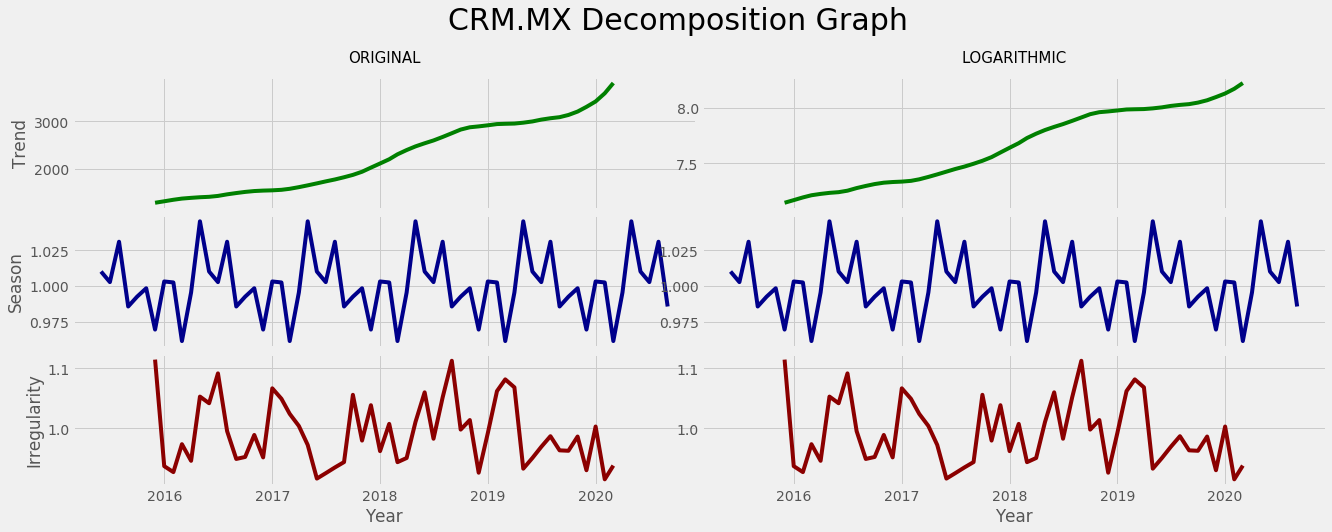

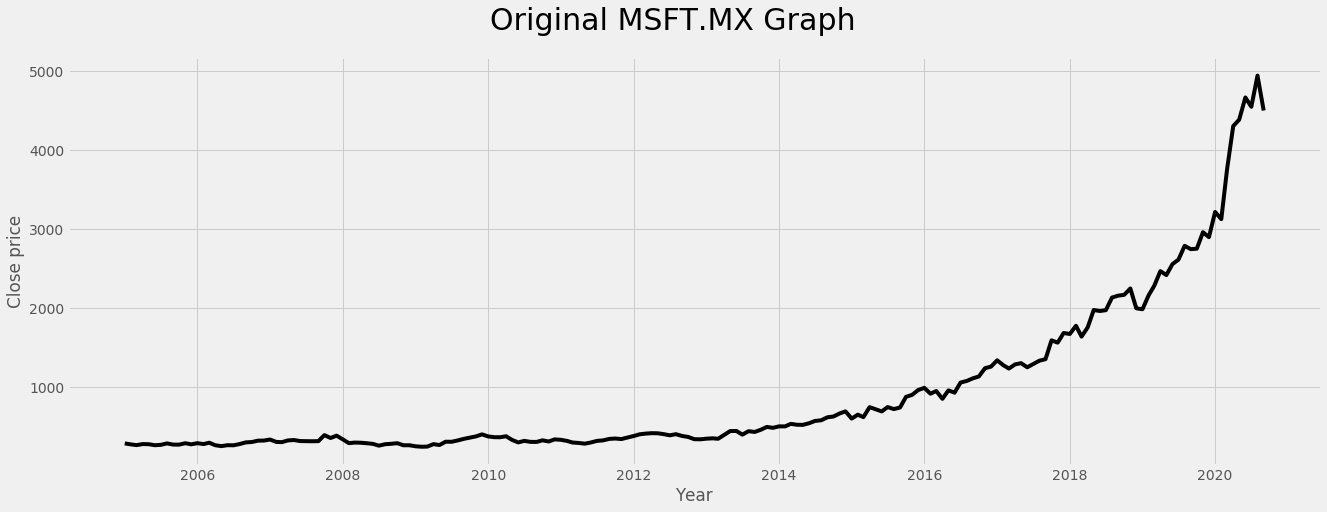

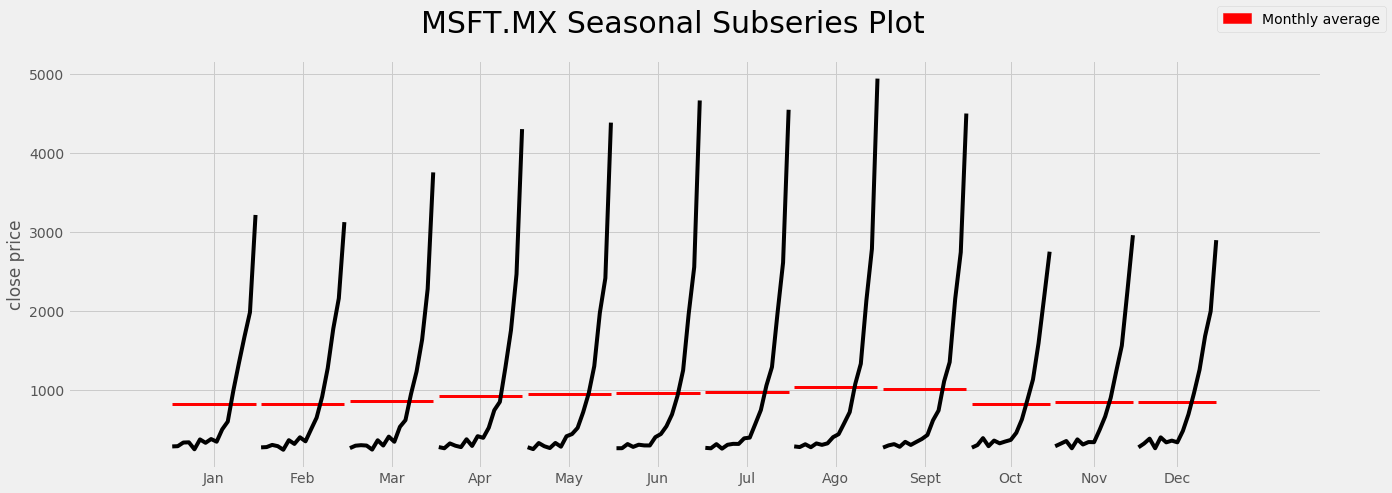

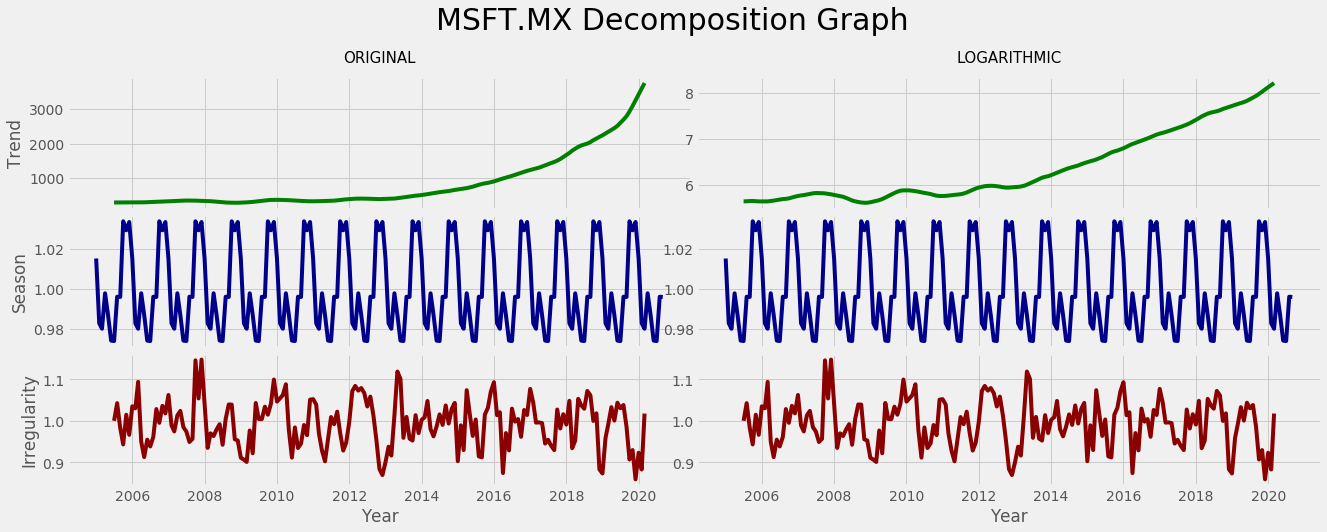

In [46]:
names = ['APPLE.MX.csv', 'GOOGL.MX.csv', 'IBM.MX.csv', 'NFLX.MX.csv', 'CRM.MX.csv', 'MSFT.mx.csv']

for i in names:
    graficar(i)
    print('\n' * 6)